In [38]:
import numpy as np
import matplotlib.pyplot as plt
from tree_serialisation import load_tree
from data_simulation import scale_branches_length, rate_sub_HKY, generate_case
from felsenstein import np_pruning
from viterbi_sumproduct import viterbi, sum_product
from model_evaluation import single_decoding_routine

Example 1: a toy gene finder

In [20]:
## Definition of the parameters 

alphabet = ['A', 'C', 'T', 'G']
alphabetSize = len(alphabet)
nbState = 4
animalNames = ["dog", "cat", "pig", "cow", "rat", "mouse", "baboon", "human"]
n_species = len(animalNames)
number_of_nucleotids = 200

# State-transition matrix
A = np.zeros((nbState, nbState))
A[0, 1] = 1
A[1, 2] = 1
A[2, 3] = 0.011
A[2, 0] = 1 - A[2, 3]
A[3, 3] = 0.33  # 0.9999  # unrealistic ...
A[3, 0] = 1 - A[3, 3]

# Initial-state probabilities
b = np.array([0.25, 0.25, 0.26, 0.24])

# Loading the phylogenetic model from JSON
tree_path = 'tree.json'
tree = load_tree(tree_path)
trees = []

for j in range(nbState):
    trees.append(scale_branches_length(tree))


pi = np.zeros((nbState, alphabetSize))
# substitution rates for pi 0 and 1 are between 0 and 0.001
pi[0] = np.random.rand(alphabetSize) * 0.001
pi[1] = np.random.rand(alphabetSize) * 0.001
# but between 0 and 0.01 for pi 2 and 3
pi[2] = np.random.rand(alphabetSize) * 0.01
pi[3] = np.random.rand(alphabetSize) * 0.01
pi /= pi.sum(axis=1)[:, None]

# translation/transversion rate
kappa = np.array([2.3, 2.7, 4.3, 5.4])

# Rate substitution matrix
Q = rate_sub_HKY(pi, kappa)

In [21]:
strands, states = generate_case(A, b, pi, kappa, trees, number_of_nucleotids)

# Transform strands from ints to strings
str_strands = list()
for strand in strands:
    str_strand = ""
    for acid_int in strand:
        str_strand = ''.join([str_strand, alphabet[acid_int]])
    str_strands += [str_strand]
str_strands

# Transform strands in sites
sites = list()
for site_ind in range(number_of_nucleotids):
    sites += [''.join([str_strands[species_ind][site_ind] for species_ind in range(n_species)])]

In [22]:
# Emission probas computation
emission_probas = np.zeros((nbState, number_of_nucleotids))
for state in range(nbState):
    for site_ind, site in enumerate(sites):
        emission_probas[state, site_ind] = pruning(Q[state], pi[state], trees[state], site)

In [23]:
# Viterbi
state_sequence_viterbi = viterbi(range(nbState), A, b, emission_probas)

/home/kimia/Documents/MVA/PGM/Project/phylo-hmm/viterbi_sumproduct.py:49: RuntimeWarning: divide by zero encountered in log
  prob = np.log(A[:, s]) + alpha_log[:, t - 1]


In [14]:
# Precision 
np.sum(states == state_sequence_viterbi) / number_of_nucleotids 
# Weird score...

0.995

Example 2: identification of highly conserved regions

In [112]:
## Definition of the parameters

animalNames = ["dog", "cat", "pig", "cow", "rat", "mouse", "baboon", "human", "chimp"]
n_species = len(animalNames)
n_states = len(animalNames) + 1
n_nucleotids = 500

alphabet = ['A', 'C', 'T', 'G']
alphabetSize = len(alphabet)

# State-transition matrix
lmbda = 0.94
a = lmbda + 1/n_states*(1-lmbda)
b = 1/n_states*(1-lmbda)

A = b*np.ones((n_states, n_states))
for i in range(n_states):
    A[i, i] = a
    
# Initial-state probabilities (hypthesis: uniform distribution)
b = np.ones(n_states) / n_states

In [113]:
# Loading the phylogenetic model from JSON
tree_path = 'tree_ex2.json'
tree = load_tree(tree_path)
trees = []
scaling_factor = [0.6, 1.1, 1.8, 2.2, 2.5, 3.0, 3.2, 3.5, 3.9, 4.3] # to be defined!

for j in range(n_states):
    trees.append(scale_branches_length(tree, scale=scaling_factor[j]))

In [114]:
# pi = np.zeros((n_states, alphabetSize))
# # substitution rates for pi 0 and 1 are between 0 and 0.001
# pi[0] = np.random.rand(alphabetSize) * 0.001
# pi[1] = np.random.rand(alphabetSize) * 0.001
# # but between 0 and 0.01 for pi 2 and 3
# pi[2] = np.random.rand(alphabetSize) * 0.01
# pi[3] = np.random.rand(alphabetSize) * 0.01
# pi /= pi.sum(axis=1)[:, None]

# Case 1 (easy)
pi = np.random.rand(n_states, alphabetSize)
pi /= pi.sum(axis=1)[:, None]

# Case 2 (complicated)
# pi = np.random.uniform(0.15, 0.35, (nbState, alphabetSize))
# pi /= pi.sum(axis=1)[:, None]

# translation/transversion rate
kappa = 2.0*np.ones(10)

In [115]:
strands, states = generate_case(A, b, pi, kappa, trees, n_nucleotids)
states

array([8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 7, 7, 7,
       7, 8, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 8, 8, 8, 7, 7, 7,
       7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       1, 1,

In [116]:
Qs = rate_sub_HKY(pi, kappa)

# Process likelihoods with Felsenstein's algorithm
likelihoods = np.zeros((n_states, n_nucleotids))
sites = np.zeros((n_nucleotids, n_species))
for i in range(n_species):
    sites[:, i] = strands[i]
for state in range(n_states):
    tree = trees[state]
    Q = Qs[state]
    p = pi[state]
    likelihoods[state] = np_pruning(Q, p, tree, sites)

In [117]:
# Posterior probas computation
post_probas = sum_product(A, b, likelihoods)
np.argmax(post_probas, axis=0)
pi

array([[ 0.160526  ,  0.2636557 ,  0.28209246,  0.29372583],
       [ 0.42111582,  0.18536932,  0.14504585,  0.24846901],
       [ 0.37576575,  0.34665949,  0.08496973,  0.19260503],
       [ 0.34919549,  0.19672631,  0.25427791,  0.19980028],
       [ 0.266372  ,  0.29809236,  0.33784116,  0.09769449],
       [ 0.04867874,  0.33684194,  0.34108056,  0.27339876],
       [ 0.3833356 ,  0.39642689,  0.2195665 ,  0.00067101],
       [ 0.43542334,  0.11770722,  0.31156107,  0.13530837],
       [ 0.42209467,  0.02748357,  0.35199557,  0.1984262 ],
       [ 0.29171714,  0.25709692,  0.37045286,  0.08073307]])

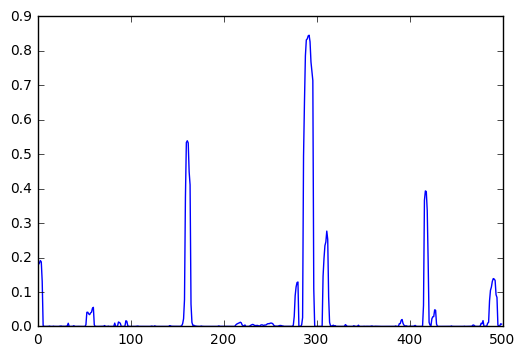

In [118]:
interest = post_probas[0, :]
interest
plt.plot(post_probas[0,:])
plt.show()